In [ ]:

import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from itertools import product
import os.path as osp
from scipy.optimize import leastsq
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import math
import time
import sunode
import sunode.wrappers.as_aesara
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
from IPython.display import display as print


In [7]:
test_model = pm.Model()

mu = 4
sigma= 0.1

with test_model:
    
    normal = pm.Normal('normal',mu=mu, sigma=sigma)
    lognormal = pm.LogNormal('lognormal',mu=mu, sigma=sigma)
    halfnormal = pm.HalfNormal('halfnormal', sigma = sigma)
    
    
    aa = normal + lognormal
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [normal, lognormal, halfnormal]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [8]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
normal,4.000,0.100,3.823,4.195,0.002,0.001,2374.0,2436.0,1.0
lognormal,54.784,5.408,45.119,65.427,0.106,0.075,2550.0,2329.0,1.0
halfnormal,0.079,0.060,0.000,0.186,0.001,0.001,1830.0,1633.0,1.0


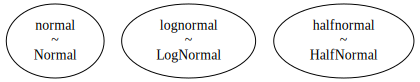

In [13]:
pm.model_to_graphviz(test_model)

In [12]:

np.exp(mu + sigma**2/2)


54.87182439907008

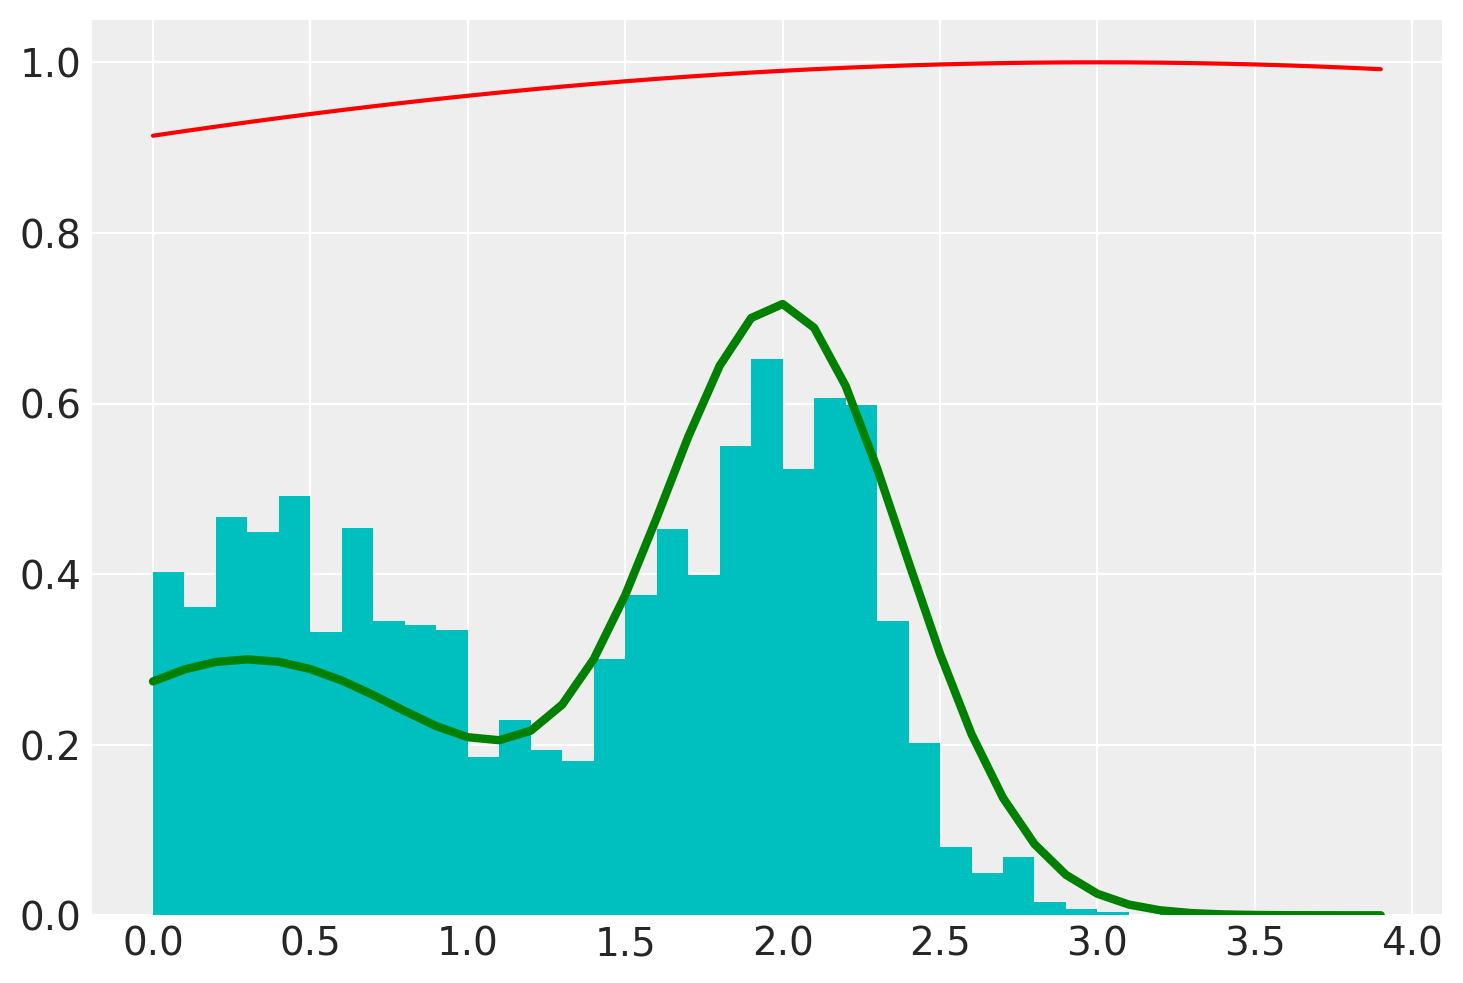

In [29]:
from __future__ import division

import numpy as np
import matplotlib.pylab as plt


mu = 3
sigma = 10


# 转移矩阵Q,因为是模拟数字，只有一维，所以Q是个数字(1*1)
def q(x):
    return np.exp(-(x-mu)**2/(sigma**2))


# 按照转移矩阵Q生成样本
def qsample():
    return np.random.normal(mu, sigma)


# 目标分布函数p(x)
def p(x):
    return 0.3*np.exp(-(x-0.3)**2) + 0.7* np.exp(-(x-2.)**2/0.3)


def mcmcsample(n = 20000):
    sample = np.zeros(n)
    sample[0] = 0.5 # 初始化
    for i in range(n-1):
        qs = qsample()  # 从转移矩阵Q(x)得到样本xt
        u = np.random.rand()  # 均匀分布
        alpha_i_j = (p(qs) * q(sample[i])) / (p(sample[i]) * qs)   # alpha(i, j)表达式
        if u < min(alpha_i_j, 1):
            sample[i + 1] = qs  # 接受
        else:
            sample[i + 1] = sample[i]  # 拒绝

    return sample


x = np.arange(0, 4, 0.1)
realdata = p(x)
sampledata = mcmcsample()
plt.plot(x, realdata, 'g', lw = 3)  # 理想数据
plt.plot(x,q(x),'r')  # Q(x)转移矩阵的数据
plt.hist(sampledata, bins=x, density=True, fc='c')  # 采样生成的数据
plt.show()


In [17]:
np.linalg.norm([1,2,2,3,3])

5.196152422706632

In [34]:
ax = pm.Binomial.dist(n=10, p=0.2)
ax

binomial_rv{0, (0, 0), int64, False}.out

In [1]:
from sympy import symbols, Eq, Function,dsolve,sin,Derivative
import sympy as sm
from sympy.solvers.ode.systems import dsolve_system


In [12]:

f = symbols('f', cls = Function)
x = symbols("x")
diffeq = Eq(f(x).diff(x, 2) - 2*f(x).diff(x) + f(x), sm.sin(x))
diffeq


Eq(f(x) - 2*Derivative(f(x), x) + Derivative(f(x), (x, 2)), sin(x))

In [13]:
f, g = symbols("f g", cls=Function)
x, alpha= symbols("x alpha")
eqs = [Eq(f(x).diff(x),  alpha*g(x)), Eq(g(x).diff(x), f(x))]
res = dsolve_system(eqs)
for x in res[0]:
    print(x)


Eq(f(x), -C1*sqrt(alpha)*exp(-sqrt(alpha)*x) + C2*sqrt(alpha)*exp(sqrt(alpha)*x))

Eq(g(x), C1*exp(-sqrt(alpha)*x) + C2*exp(sqrt(alpha)*x))

In [19]:
class Parames(object):
    def __init__(self):
        for x in range(11):
            setattr(self, f'k{x+1}', symbols(f"k{x+1}") )
    
class CCTS(object):
    def __init__(self, t):
        cct_names = ['xNH3', 'xNO3', 'xNO2', 'xNOrg', 'xN2', 'ANH3','ANO3','ANO2','ANOrg','AN2']
        
        for _c in cct_names:
            _f = symbols(f'{_c}', cls=Function)
            setattr(self, f'{_c}', _f(t) )
            setattr(self, f'dc_{_c}', _f(t).diff(t) )
        
def get_diff_eqs(t, c, p):
    
    k_kinetics = np.repeat(1, 11).astype(np.uint8)
    r1 = p.k1 * c.xN2 if k_kinetics[0] == 1 else p.k1
    r2 = p.k2 * c.xNH3 if k_kinetics[1] == 1 else p.k2
    r3 = p.k3 * c.xNO2 if k_kinetics[2] == 1 else p.k3
    r4 = p.k4 * c.xNO3 if k_kinetics[3] == 1 else p.k4
    r5 = p.k5 * c.xNO2 if k_kinetics[4] == 1 else p.k5
    r6 = p.k6 * c.xNO2 * c.xNO3 if k_kinetics[5] == 1 else p.k6
    r7 = p.k7 * c.xNO3 if k_kinetics[6] == 1 else p.k7
    r8 = p.k8 * c.xNO3 if k_kinetics[7] == 1 else p.k8
    r9 = p.k9 * c.xNH3 if k_kinetics[8] == 1 else p.k9
    r10 = p.k10 * c.xNOrg if k_kinetics[9] == 1 else p.k10
    r11 = p.k11 * c.xNOrg if k_kinetics[10] == 1 else p.k11

    
    dc_xNH3 = Eq(c.dc_xNH3, 2 * r1 + r7 + r10 - r2 - r6 - r9)
    dc_xNO3 = Eq(c.dc_xNO3, r3 - r7 - r4 - r8 + r11)
    dc_xNO2 = Eq(c.dc_xNO2, r2 + r4 - r3 - r6 - 2 * r5)
    dc_xNOrg =Eq(c.dc_xNOrg,  r8 + r9 - r10 - r11)
    dc_xN2 = Eq(c.dc_xN2, r5 + r6 - r1)

    dc_ANH3 = Eq(c.dc_ANH3, (2 * r1 * (c.AN2 - c.ANH3) + (c.ANO3 - c.ANH3) * r7 + (c.ANOrg - c.ANH3) * r10) / c.xNH3)
    dc_ANO3 = Eq(c.dc_ANO3, ((c.ANO2 - c.ANO3) * r2 + (c.ANOrg - c.ANO3) * r11) / c.xNO3)
    dc_ANO2 = Eq(c.dc_ANO2, ((c.ANH3 - c.ANO2) * r2 + (c.ANO3 - c.ANO2) * r4) / c.xNO2)
    dc_ANOrg = Eq(c.dc_ANOrg, ((c.ANO3 - c.ANOrg) * r8 + (c.ANH3 - c.ANOrg) * r9) / c.xNOrg)
    dc_AN2 = Eq(c.dc_AN2, ((c.ANO2 - c.AN2) * r5 + (c.ANO2 * c.ANH3 - c.AN2) * r6) / c.xN2)
    
    dcdts = [dc_xNH3, dc_xNO3, dc_xNO2, dc_xNOrg, dc_xN2, dc_ANH3, dc_ANO3, dc_ANO2, dc_ANOrg, dc_AN2]
    
    
    # dcdts =  {
    #     'xNH3': dc_xNH3,
    #     'xNO3': dc_xNO3,
    #     'xNO2': dc_xNO2,
    #     'xNOrg': dc_xNOrg,
    #     'xN2': dc_xN2,
    #     'ANH3': dc_ANH3,
    #     'ANO3': dc_ANO3,
    #     'ANO2': dc_ANO2,
    #     'ANOrg': dc_ANOrg,
    #     'AN2': dc_AN2,
    # }

    return dcdts


t= symbols("t")

eqs = get_diff_eqs(t,CCTS(t), Parames())

for x in eqs:
    print(x)


Eq(Derivative(xNH3(t), t), 2*k1*xN2(t) + k10*xNOrg(t) - k2*xNH3(t) - k6*xNO2(t)*xNO3(t) + k7*xNO3(t) - k9*xNH3(t))

Eq(Derivative(xNO3(t), t), k11*xNOrg(t) + k3*xNO2(t) - k4*xNO3(t) - k7*xNO3(t) - k8*xNO3(t))

Eq(Derivative(xNO2(t), t), k2*xNH3(t) - k3*xNO2(t) + k4*xNO3(t) - 2*k5*xNO2(t) - k6*xNO2(t)*xNO3(t))

Eq(Derivative(xNOrg(t), t), -k10*xNOrg(t) - k11*xNOrg(t) + k8*xNO3(t) + k9*xNH3(t))

Eq(Derivative(xN2(t), t), -k1*xN2(t) + k5*xNO2(t) + k6*xNO2(t)*xNO3(t))

Eq(Derivative(ANH3(t), t), (2*k1*(AN2(t) - ANH3(t))*xN2(t) + k10*(-ANH3(t) + ANOrg(t))*xNOrg(t) + k7*(-ANH3(t) + ANO3(t))*xNO3(t))/xNH3(t))

Eq(Derivative(ANO3(t), t), (k11*(-ANO3(t) + ANOrg(t))*xNOrg(t) + k2*(ANO2(t) - ANO3(t))*xNH3(t))/xNO3(t))

Eq(Derivative(ANO2(t), t), (k2*(ANH3(t) - ANO2(t))*xNH3(t) + k4*(-ANO2(t) + ANO3(t))*xNO3(t))/xNO2(t))

Eq(Derivative(ANOrg(t), t), (k8*(ANO3(t) - ANOrg(t))*xNO3(t) + k9*(ANH3(t) - ANOrg(t))*xNH3(t))/xNOrg(t))

Eq(Derivative(AN2(t), t), (k5*(-AN2(t) + ANO2(t))*xNO2(t) + k6*(-AN2(t) + ANH3(t)*ANO2(t))*xNO2(t)*xNO3(t))/xN2(t))

In [20]:
# dsolve(eqs)
dsolve_system(eqs)

NotImplementedError: 
The system of ODEs passed cannot be solved by dsolve_system.

In [17]:
t, alpha, beta, delta, gamma = symbols("t alpha, beta, delta, gamma")
H, L = symbols("H, L", cls=Function)

eqs = [Eq(H(t).diff(t), alpha * H(t) - beta*L(t)*H(t)), Eq(L(t).diff(t), delta*L(t)*H(t) - gamma * L(t))]

print(eqs[0])
print(eqs[1])
dsolve_system(eqs)
xxx = dsolve(eqs)

print(xxx)

Eq(Derivative(H(t), t), alpha*H(t) - beta*H(t)*L(t))

Eq(Derivative(L(t), t), delta*H(t)*L(t) - gamma*L(t))

NotImplementedError: 
The system of ODEs passed cannot be solved by dsolve_system.

In [49]:
type(sin)

sympy.core.function.FunctionClass